We solve the Neoclassical Growth Model
\begin{align}
  \rho V(k) &= \max_{c} u(c) +  V'(k)(F(k)-\delta k - c) \\
  &u(c) = \frac{c^{1-\sigma}}{1-\sigma},~~~~ F(k)=k^\alpha
\end{align}

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sigma = 2 # 1 changes to log utility
alpha = 0.3
delta = 0.05
rho = 0.05

In [3]:
kss = (alpha/(rho+delta))**(1/(1-alpha))
kmin = 0.001*kss
kmax = 2*kss

# kmin = 0
# kmax = 1

In [4]:
kmax

9.607973313346182

In [5]:
train_num = 10000
x_train = np.random.uniform(kmin,kmax,(train_num,1))
# train = np.linspace(kmin, kmax, num=train_num)
x_train

array([[4.34496008],
       [8.55459916],
       [4.40360863],
       ...,
       [7.05404361],
       [4.80661246],
       [7.94319697]])

In [6]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='tanh', input_shape=[1]), #use_bias=True
    layers.Dense(64, activation='tanh'), #use_bias=False     
    layers.Dense(64, activation='tanh'), #use_bias=False
#     layers.Dense(16, activation='relu'), #use_bias=False     
#     layers.Dense(8, activation='relu'), #use_bias=False 
#     layers.Dense(4, activation='relu'), #use_bias=False 
#     layers.Dense(2, activation='relu'), #use_bias=False   
    layers.Dense(1) #,kernel_constraint=keras.constraints.NonNeg()
  ])

  optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#   optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                )
  return model

In [7]:
model = build_model()

In [8]:
model.summary()
# model.get_weights() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,513
Trainable params: 8,513
Non-trainable params: 0
_________________________________________________________________


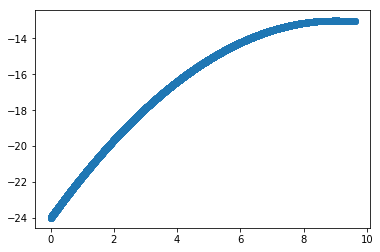

In [9]:
y_train = - 11/81*(x_train-9)**2 - 13

plt.scatter(x_train,y_train)

In [10]:
model.fit( x_train, y_train, epochs=50,validation_split = 0.2, verbose=1 ) # ,batch_size=5000

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 1s 74us/sample - loss: 33.9566 - val_loss: 11.2643
Epoch 2/50
8000/8000 [==============================] - 0s 49us/sample - loss: 11.0367 - val_loss: 10.8298
Epoch 3/50
8000/8000 [==============================] - 0s 49us/sample - loss: 10.8228 - val_loss: 10.7268
Epoch 4/50
8000/8000 [==============================] - 0s 47us/sample - loss: 10.5369 - val_loss: 9.5338
Epoch 5/50
8000/8000 [==============================] - 0s 47us/sample - loss: 6.1875 - val_loss: 3.4414
Epoch 6/50
8000/8000 [==============================] - 0s 47us/sample - loss: 2.5301 - val_loss: 1.6794
Epoch 7/50
8000/8000 [==============================] - 0s 47us/sample - loss: 1.1829 - val_loss: 0.8216
Epoch 8/50
8000/8000 [==============================] - 0s 47us/sample - loss: 0.4514 - val_loss: 0.2553
Epoch 9/50
8000/8000 [==============================] - 0s 48us/sample - loss: 0.1858 - val_loss: 0.1347


0.010117558294321686


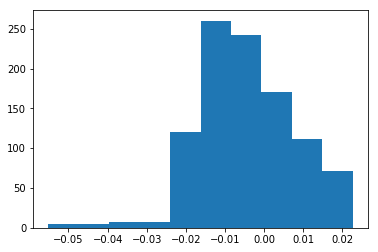

In [11]:
x_test = np.linspace(kmin,kmax,num=1000)

y_test = - 11/81*(x_test-9)**2 - 13

error = y_test.reshape(1000,1) - model.predict([x_test])

print(np.mean(abs(error)))

plt.hist(error, bins=10) 
plt.show()

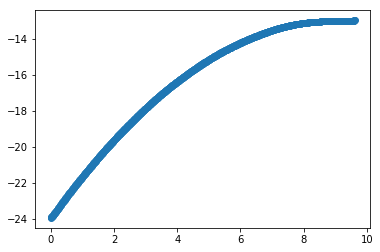

In [12]:
plt.scatter(x_test,model.predict([x_test]))

In [13]:
inputs = tf.constant(x_train)
with tf.GradientTape() as t: #(persistent=True)
    t.watch(inputs)
    output = model(inputs)
derivative = t.gradient(output, inputs).numpy()
print(derivative)

[[1.25788355]
 [0.10300608]
 [1.24466133]
 ...
 [0.55640173]
 [1.14448023]
 [0.24768469]]


In [14]:
# np.ones(train_num).reshape(train_num,1).shape

In [15]:
update = 1
dt = 5*1e-2
criteria = 1e-2
converge_error = 10

In [16]:
# for update in range(update):
while converge_error > criteria and update<200:
        value = model.predict([x_train])
#         print(type(value))

        with tf.GradientTape() as t: #(persistent=True)
            t.watch(inputs)
            output = model(inputs)
            
        derivative = t.gradient(output, inputs).numpy()
#         print(derivative)

        for i in range(train_num):
            derivative[i] = np.maximum(derivative[i], 1e-4)
            
        # with log utility function
#         HJB = np.log(1/derivative)+derivative*((train)**alpha-delta*train-1/derivative)-rho*value

        # with sigma=2 CRRA utility function
        HJB = (1/np.sqrt(derivative))**(1-sigma)/(1-sigma)+derivative*((x_train)**alpha-delta*x_train-1/np.sqrt(derivative))-rho*value
#         print(HJB)
        value += dt*HJB
        model.fit( x_train, value,  epochs=10, validation_split = 0.2, verbose=0 )
        
        update += 1
        converge_error = np.mean(abs(HJB))
        print(update,  max(abs(HJB)), np.mean(abs(HJB)))

2 [1.11809516] 0.2059371336043937
3 [1.16268856] 0.20221425246095284
4 [1.20487628] 0.19933587718377727
5 [1.25887959] 0.19537784118484225
6 [1.31173756] 0.19162063475637287
7 [1.36857447] 0.18839787215831158
8 [1.41464639] 0.1854183318072135
9 [1.45889325] 0.18133907984750253
10 [1.4784609] 0.17936085960999923
11 [1.51412618] 0.1777334206079184
12 [1.56046839] 0.1758748841129998
13 [1.59016839] 0.17604531323231112
14 [1.62864807] 0.173636424255321
15 [1.68788862] 0.17195895795934762
16 [1.74160644] 0.17021911472627957
17 [1.78012896] 0.1683633602607113
18 [1.79666386] 0.16769557123934314
19 [1.83634121] 0.16550132163504505
20 [1.88341266] 0.1640645832413816
21 [2.01509113] 0.16328372493500715
22 [2.07884197] 0.16243784185153934
23 [2.1498734] 0.16332689386655969
24 [2.23996722] 0.16156459187268846
25 [2.339574] 0.15963937228391614
26 [2.4458612] 0.1577433456672321
27 [2.59962659] 0.15639343236342249
28 [2.9524642] 0.15823233742843965
29 [2.94066036] 0.15613688965181827
30 [2.98897296]

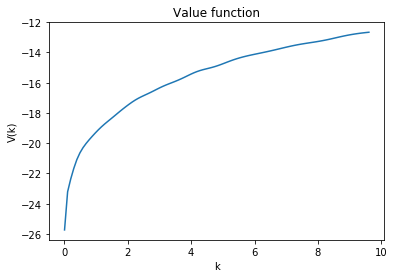

In [17]:
x = np.linspace(kmin, kmax, num=100)
y = model.predict([x])


plt.plot(x,y)

plt.xlabel('k')
plt.ylabel('V(k)')
plt.title('Value function')
plt.show()

In [19]:
from tensorflow.keras.models import load_model

model.save('NCG_TD.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')